In [1]:
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.keras as iso

import scipy.optimize as spopt
from scipy.stats import pearsonr

#Logistic regression prediction
def get_y_pred(X, w, w_0) :
    return 1. / (1. + np.exp(-1. * (X.dot(w) + w_0)))

#Safe log for NLL
def safe_log(x, minval=0.01):
    return np.log(x.clip(min=minval))

#Logistic regression NLL loss
def log_loss(w_bundle, *fun_args) :
    (X, y, lambda_penalty) = fun_args
    w = w_bundle[1:]
    w_0 = w_bundle[0]
    N = float(X.shape[0])

    log_y_zero = safe_log(1. - get_y_pred(X, w, w_0))
    log_y_one = safe_log(get_y_pred(X, w, w_0))

    log_loss = (1. / 2.) * lambda_penalty * np.square(np.linalg.norm(w)) - (1. / N) * np.sum(y * log_y_one + (1. - y) * log_y_zero)

    return log_loss

#Logistic regression NLL gradient
def log_loss_gradient(w_bundle, *fun_args) :
    (X, y, lambda_penalty) = fun_args
    w = w_bundle[1:]
    w_0 = w_bundle[0]
    N = float(X.shape[0])

    y_pred = get_y_pred(X, w, w_0)

    w_0_gradient = - (1. / N) * np.sum(y - y_pred)
    w_gradient = 1. * lambda_penalty * w - (1. / N) * X.T.dot(y - y_pred)

    return np.concatenate([[w_0_gradient], w_gradient])


Using TensorFlow backend.


In [2]:
#Load 5'ss plasmid data
plasmid_dict = pickle.load(open('../data/a5ss/processed_data/alt_5ss_data.pickle', 'rb'))

#Generate training and test set indexes
valid_set_size=0.05
test_set_size=0.05

plasmid_index = np.arange(len(plasmid_dict['min_df']), dtype=np.int)#[:10000]

plasmid_train_index = plasmid_index[:-int(len(plasmid_index) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_index) * valid_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))

Training set size = 238183
Validation set size = 13232
Test set size = 13232


In [3]:

seq_start_1 = 147
seq_start_2 = 147 + 25 + 18
splice_donor_pos = 140

plasmid_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : plasmid_dict['min_df'],
            'hek_cuts' : plasmid_dict['min_hek_count'],
            'hela_cuts' : plasmid_dict['min_hela_count'],
            'mcf7_cuts' : plasmid_dict['min_mcf7_count'],
            'cho_cuts' : plasmid_dict['min_cho_count'],
        },
        batch_size=len(idx),
        inputs = [
            {
                'id' : 'random_region_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_seq'][seq_start_1 - 6 + 1: seq_start_1 + 25 + 6 - 1],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            },
            {
                'id' : 'random_region_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_seq'][seq_start_2 - 6 + 1: seq_start_2 + 25 + 6 - 1],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            }
        ],
        outputs = [
            {
                'id' : 'hek_sd_usage',
                'source_type' : 'matrix',
                'source' : 'hek_cuts',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=False),
                'transformer' : lambda t: t[0] / np.sum(t)
            },
            {
                'id' : 'hela_sd_usage',
                'source_type' : 'matrix',
                'source' : 'hela_cuts',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=False),
                'transformer' : lambda t: t[0] / np.sum(t)
            },
            {
                'id' : 'mcf7_sd_usage',
                'source_type' : 'matrix',
                'source' : 'mcf7_cuts',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=False),
                'transformer' : lambda t: t[0] / np.sum(t)
            },
            {
                'id' : 'cho_sd_usage',
                'source_type' : 'matrix',
                'source' : 'cho_cuts',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=False),
                'transformer' : lambda t: t[0] / np.sum(t)
            }
        ],
        randomizers = [],
        shuffle = False,
        densify_batch_matrices=True
    ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
}


Generating train and test data for all cell lines...
Starting logistic n-mer regression for cell line hek...
Regression finished.
Test set R^2 = 0.76, p = 0.0


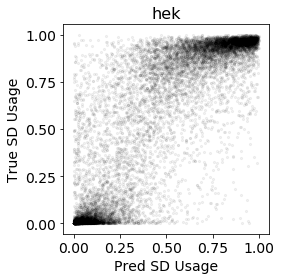

Starting logistic n-mer regression for cell line hela...
Regression finished.
Test set R^2 = 0.77, p = 0.0


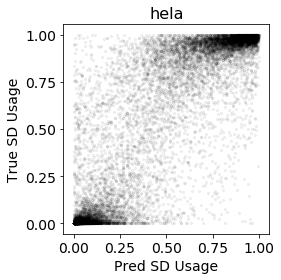

Starting logistic n-mer regression for cell line mcf7...
Regression finished.
Test set R^2 = 0.75, p = 0.0


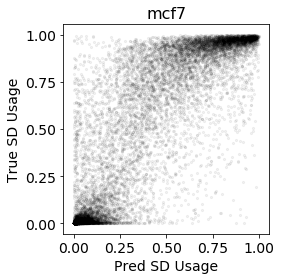

Starting logistic n-mer regression for cell line cho...
Regression finished.
Test set R^2 = 0.78, p = 0.0


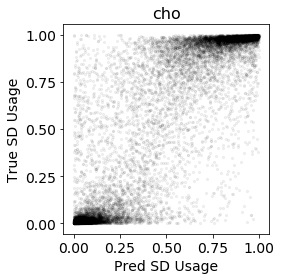

In [4]:

stored_nmer_weights = {
    'nmer' : ['bias'] + [t[1] for t in sorted(plasmid_gens['train'].encoders['random_region_1'].encoder.decode_map.items(), key=lambda t: t[0])],
    'hek' : None,
    'hela' : None,
    'mcf7' : None,
    'cho' : None,
}

print("Generating train and test data for all cell lines...")

#Get training data from generator
[X_up_train, _], [y_train_hek, y_train_hela, y_train_mcf7, y_train_cho] = plasmid_gens['train'][0]
X_train = X_up_train

#Get test data from generator
[X_up_test, _], [y_test_hek, y_test_hela, y_test_mcf7, y_test_cho] = plasmid_gens['test'][0]
X_test = X_up_test

for cell_line in [('hek', (y_train_hek, y_test_hek)), ('hela', (y_train_hela, y_test_hela)), ('mcf7', (y_train_mcf7, y_test_mcf7)), ('cho', (y_train_cho, y_test_cho))] :
    cell_name, [y_train, y_test] = cell_line
    
    print("Starting logistic n-mer regression for cell line " + str(cell_name) + "...")

    w_init = np.zeros(X_train.shape[1] + 1)
    lambda_penalty = 0

    (w_bundle, _, _) = spopt.fmin_l_bfgs_b(log_loss, w_init, fprime=log_loss_gradient, args=(X_train, y_train, lambda_penalty), maxiter = 200)

    print("Regression finished.")
    
    #Store weights
    w = w_bundle[1:]
    w_0 = w_bundle[0]
    
    stored_nmer_weights[cell_name] = w_bundle.tolist()

    #Evaluate predictions on test set
    y_test_pred = get_y_pred(X_test, w, w_0)
    r_val, p_val = pearsonr(y_test_pred, y_test)
    print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

    #Plot test set scatter
    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_test_pred, y_test, color='black', s=5, alpha=0.05)
    
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.xlabel('Pred SD Usage', fontsize=14)
    plt.ylabel('True SD Usage', fontsize=14)
    plt.title(str(cell_name), fontsize=16)
    
    plt.tight_layout()
    plt.show()

nmer_df = pd.DataFrame(stored_nmer_weights)
nmer_df = nmer_df[['nmer', 'hek', 'hela', 'mcf7', 'cho']]

nmer_df.to_csv('alt_5ss_6mers.csv', index=False, sep='\t')


In [5]:
nmer_df = pd.read_csv('alt_5ss_nmers.csv', sep='\t')

nmer_df.head()

,nmer,hek,hela,mcf7,cho
0,bias,-2.102107,-2.124408,-2.303739,-2.021327
1,AAAAAA,0.074255,0.082266,0.072875,0.082434
2,AAAAAC,0.023594,0.036518,0.004113,0.026674
3,AAAAAG,-0.000862,0.004437,-0.006435,0.004502
4,AAAAAT,0.096080,0.120073,0.103336,0.118900


In [6]:

hek_w_0 = nmer_df.iloc[0]['hek']
hek_w = np.array(nmer_df.iloc[1:]['hek'].values)

hela_w_0 = nmer_df.iloc[0]['hela']
hela_w = np.array(nmer_df.iloc[1:]['hela'].values)

mcf7_w_0 = nmer_df.iloc[0]['mcf7']
mcf7_w = np.array(nmer_df.iloc[1:]['mcf7'].values)

cho_w_0 = nmer_df.iloc[0]['cho']
cho_w = np.array(nmer_df.iloc[1:]['cho'].values)


In [7]:
[X_up, X_dn], [y_hek, y_hela, y_mcf7, y_cho] = plasmid_gens['all'][0]
X = X_up


In [8]:
y_hek_pred = get_y_pred(X, hek_w, hek_w_0)
y_hela_pred = get_y_pred(X, hela_w, hela_w_0)
y_mcf7_pred = get_y_pred(X, mcf7_w, mcf7_w_0)
y_cho_pred = get_y_pred(X, cho_w, cho_w_0)

In [9]:
pred_df = plasmid_dict['min_df'].copy()

pred_df['sd1_true_hek'] = y_hek
pred_df['sd1_true_hela'] = y_hela
pred_df['sd1_true_mcf7'] = y_mcf7
pred_df['sd1_true_cho'] = y_cho

pred_df['sd1_pred_hek'] = y_hek_pred
pred_df['sd1_pred_hela'] = y_hela_pred
pred_df['sd1_pred_mcf7'] = y_mcf7_pred
pred_df['sd1_pred_cho'] = y_cho_pred

pred_df['total_count_hek'] = plasmid_dict['min_hek_count'].sum(axis=-1)
pred_df['total_count_hela'] = plasmid_dict['min_hela_count'].sum(axis=-1)
pred_df['total_count_mcf7'] = plasmid_dict['min_mcf7_count'].sum(axis=-1)
pred_df['total_count_cho'] = plasmid_dict['min_cho_count'].sum(axis=-1)

pred_df['is_train'] = np.zeros(len(pred_df))
pred_df.loc[plasmid_train_index, 'is_train'] = 1

pred_df['is_valid'] = np.zeros(len(pred_df))
pred_df.loc[plasmid_valid_index, 'is_valid'] = 1

pred_df['is_test'] = np.zeros(len(pred_df))
pred_df.loc[plasmid_test_index, 'is_test'] = 1

pred_df.to_csv('alt_5ss_6mer_pred.csv', index=False, sep='\t')


In [5]:
splicing_df = pd.read_csv('alt_5ss_6mer_pred.csv', sep='\t')

train_df = splicing_df.query("is_train == 1")
valid_df = splicing_df.query("is_valid == 1")
test_df = splicing_df.query("is_test == 1")

Test set R^2 = 0.76, p = 0.0


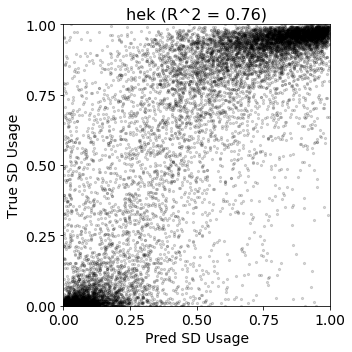

Test set R^2 = 0.77, p = 0.0


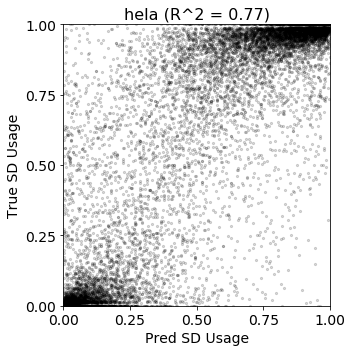

Test set R^2 = 0.75, p = 0.0


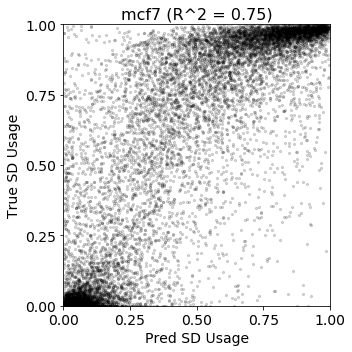

Test set R^2 = 0.78, p = 0.0


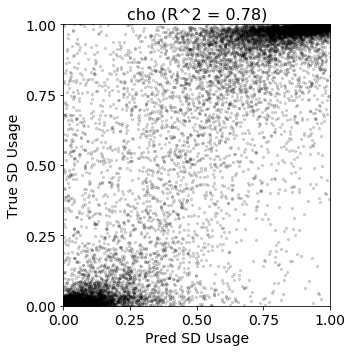

In [11]:

save_figs = False

pred_df = test_df

for cell_type in ['hek', 'hela', 'mcf7', 'cho'] :
    
    #Plot test set scatter
    f = plt.figure(figsize=(5, 5))
    
    r_val, p_val = pearsonr(pred_df['sd1_pred_' + cell_type], pred_df['sd1_true_' + cell_type])
    print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

    plt.scatter(pred_df['sd1_pred_' + cell_type], pred_df['sd1_true_' + cell_type], color='black', s=5, alpha=0.15)
    
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.xlabel('Pred SD Usage', fontsize=14)
    plt.ylabel('True SD Usage', fontsize=14)
    plt.title(str(cell_type) + " (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    
    if save_figs :
        plt.savefig('logistic_regression_test_scatter_' + cell_type + '.png', transparent=True, dpi=150)
        plt.savefig('logistic_regression_test_scatter_' + cell_type + '.eps')
        plt.savefig('logistic_regression_test_scatter_' + cell_type + '.svg')
    
    plt.show()


Diff pred R^2 = 0.16, p = 0.0


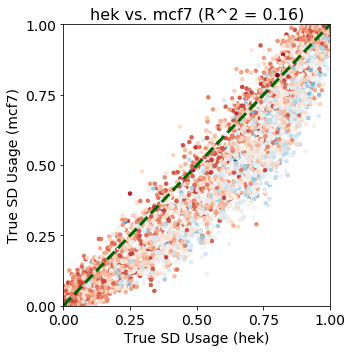

In [19]:

save_figs = False

pred_df = test_df

cell_1 = 'hek'
cell_2 = 'mcf7'

f = plt.figure(figsize=(5, 5))

r_val, p_val = pearsonr(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1], pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1])
print("Diff pred R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

min_delta = np.min(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1])
max_delta = np.max(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1])
max_abs_delta = np.abs(np.max(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1]))

plt.scatter(pred_df['sd1_true_' + cell_1], pred_df['sd1_true_' + cell_2], c=pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1], cmap='RdBu_r', vmin=min_delta, vmax=max_delta, s=12, alpha=0.95)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel('True SD Usage (' + cell_1 + ')', fontsize=14)
plt.ylabel('True SD Usage (' + cell_2 + ')', fontsize=14)
plt.title(cell_1 + ' vs. ' + cell_2 + " (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)

plt.plot([0, 1], [0, 1], color='darkgreen', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

if save_figs :
    plt.savefig('logistic_regression_test_diff_scatter_' + cell_1 + '_vs_' + cell_2 + '.png', transparent=True, dpi=150)
    plt.savefig('logistic_regression_test_diff_scatter_' + cell_1 + '_vs_' + cell_2 + '.eps')
    plt.savefig('logistic_regression_test_diff_scatter_' + cell_1 + '_vs_' + cell_2 + '.svg')

plt.show()


